In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
from statsmodels.stats.outliers_influence import variance_inflation_factor
#import dask.dataframe as dd

In [2]:
#read in members and train datafiles
members = pd.read_csv(r'E:\KKbox\members_v3.csv')
train = pd.read_csv(r'E:\KKbox\train_v2.csv')
#create training dataframe 
train = train.merge(members,how='left',on=['msno'])

In [3]:
# read in first 50 million rows of user logs file
user_logs = pd.read_csv(r'E:\KKbox\user_logs_v2.csv')
user_logs= pd.concat((user_logs,pd.read_csv(r'E:\KKbox\user_logs.csv',nrows=50000000)), axis=0, ignore_index=True).reset_index(drop=True)
user_logs['date'] = pd.to_datetime(user_logs['date'],format='%Y%m%d')
#select only logs for users that are in df
msnos = train['msno']
relevant_user_logs = user_logs.loc[user_logs['msno'].isin(msnos)]
user_logs = pd.DataFrame(index=[],columns=[])

In [4]:
#select only logs for the last two months before the churn window, which for the train set is March 2017
LastTwoMonthslogs = relevant_user_logs.loc[(relevant_user_logs['date']<'2017-03-01') & (relevant_user_logs['date']>'2016-12-31')]
relevant_user_logs = pd.DataFrame(index=[],columns=[])

In [5]:
#aggregate the logs by mean so you can have one row of log info per user
mean_user_logs = pd.DataFrame(index=[],columns=[])
mean_user_logs['num_25'] = LastTwoMonthslogs.groupby('msno')['num_25'].mean()
mean_user_logs['num_50'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_75'] = LastTwoMonthslogs.groupby('msno')['num_75'].mean()
mean_user_logs['num_985'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_100'] = LastTwoMonthslogs.groupby('msno')['num_100'].mean()
mean_user_logs['num_unq'] = LastTwoMonthslogs.groupby('msno')['num_unq'].mean()
mean_user_logs['total_secs'] = LastTwoMonthslogs.groupby('msno')['total_secs'].mean()
mean_user_logs['days_logged'] = LastTwoMonthslogs.groupby('msno')['date'].count()

In [6]:
#merge the mean log data into the dataframe
mean_user_logs = mean_user_logs.reset_index()
train = train.merge(mean_user_logs,how='left',on='msno')

In [7]:
#read in transactions data, manipulate it to create feature for number of transactions, then clear memory and add data of the 
#most recent transaction to the training dataframe
transactions = pd.read_csv(r'E:\KKbox\transactions.csv', usecols=['msno'])
transactions = pd.concat((transactions, pd.read_csv(r'E:\KKbox\transactions_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','num_transactions']
train = pd.merge(train, transactions, how='left', on='msno')
transactions = []
transactions = pd.read_csv(r'E:\KKbox\transactions_v2.csv')
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')
train = pd.merge(train, transactions, how='left', on='msno')
transactions=[]

In [8]:
train= train.fillna(0)

In [9]:
#replace columns that have categorical data with dummy variables
train = pd.get_dummies(train,columns=['city','registered_via','gender'])

In [10]:
#check how many churners are in the dataframe relative to the size of the dataframe
print(train.is_churn.sum())
print(train.shape)

87330
(970960, 52)


In [11]:
train.msno.nunique()

970960

In [ ]:
#can optionally subset the dataframe into churners and nonchurners and reconstruct with a higher ratio of churners in order to 
#produce a 'better trained model'
churners= train.loc[train['is_churn']==1]
nonchurners= train.loc[train['is_churn']==0]
nonchurners= nonchurners.sample(n=107000)
morechurnersdf = pd.concat([churners,nonchurners])

In [ ]:
#identify features and target variable for calculating VIF
y = train['is_churn']
X = train.drop(['is_churn','msno',],axis=1)

In [ ]:
#display vif of all features
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

In [13]:
train.columns

Index(['msno', 'is_churn', 'bd', 'registration_init_time', 'num_25', 'num_50',
       'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'days_logged',
       'num_transactions', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel', 'city_0.0',
       'city_1.0', 'city_3.0', 'city_4.0', 'city_5.0', 'city_6.0', 'city_7.0',
       'city_8.0', 'city_9.0', 'city_10.0', 'city_11.0', 'city_12.0',
       'city_13.0', 'city_14.0', 'city_15.0', 'city_16.0', 'city_17.0',
       'city_18.0', 'city_19.0', 'city_20.0', 'city_21.0', 'city_22.0',
       'registered_via_0.0', 'registered_via_3.0', 'registered_via_4.0',
       'registered_via_7.0', 'registered_via_9.0', 'registered_via_13.0',
       'gender_0', 'gender_female', 'gender_male'],
      dtype='object')

In [12]:
#select features and target variable for model.  Can change to eliminate high VIF features
y = train['is_churn']
#X = train.drop(['is_churn','msno',],axis=1)
#X = train.drop(['is_churn','msno','num_100','total_secs'],axis=1)
#X = train.drop(['is_churn','msno','total_secs'],axis=1)
X= train[['is_auto_renew','is_cancel','registered_via_0.0', 'registered_via_3.0', 'registered_via_4.0','registered_via_7.0', 
          'registered_via_9.0', 'registered_via_13.0',
       'gender_0', 'gender_female', 'gender_male']]

In [13]:
#split into train and test sets and initialize classifier
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=21)

In [14]:
#train
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
#make predictions on test set
y_pred = logreg.predict(X_test)

In [16]:
#check confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[173671   3043]
 [ 10788   6690]]
             precision    recall  f1-score   support

          0       0.94      0.98      0.96    176714
          1       0.69      0.38      0.49     17478

avg / total       0.92      0.93      0.92    194192



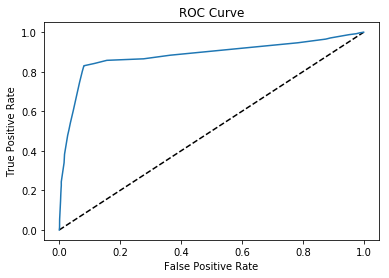

AUC: 0.8817120310353784
AUC scores computed using 5-fold cross-validation: [0.88195963 0.8815661  0.88535019 0.8870376  0.8827111 ]


In [17]:
#Check ROC curve, AUC score, and 5 fold cv AUC
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

In [18]:
#check log loss
log_loss(y_test,y_pred_prob)

0.1738358467535548

In [19]:
#model coefficients
Coefficients = pd.DataFrame()
Coefficients['features'] = X.columns
Coefficients['model_coefficients'] = np.transpose(logreg.coef_)
Coefficients

,features,model_coefficients
0,is_auto_renew,-4.052154
1,is_cancel,5.375505
2,registered_via_0.0,0.317831
3,registered_via_3.0,-0.394750
4,registered_via_4.0,-0.274589
5,registered_via_7.0,0.210269
6,registered_via_9.0,-0.119956
7,registered_via_13.0,0.286762
8,gender_0,-0.219702
9,gender_female,0.151013


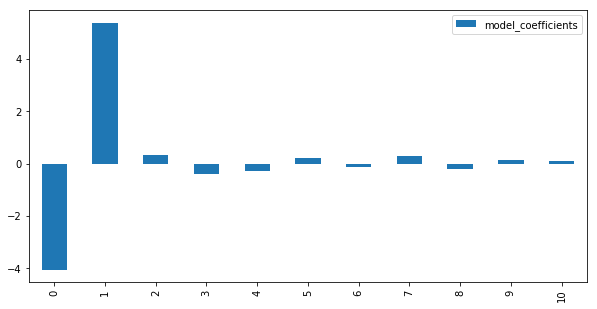

In [20]:
Coefficients.plot(kind='bar',figsize=(10,5))

In [21]:
train = []
sample_submission = pd.read_csv(r'E:\KKbox\sample_submission_v2.csv')
test = sample_submission.merge(members,how='left',on=['msno'])

In [22]:
# read in first 50 million rows of user logs file
user_logs = pd.read_csv(r'E:\KKbox\user_logs_v2.csv')
user_logs= pd.concat((user_logs,pd.read_csv(r'E:\KKbox\user_logs.csv',nrows=50000000)), axis=0, ignore_index=True).reset_index(drop=True)
user_logs['date'] = pd.to_datetime(user_logs['date'],format='%Y%m%d')
#select only logs for users that are in df
msnos = test['msno']
relevant_user_logs = user_logs.loc[user_logs['msno'].isin(msnos)]
user_logs = pd.DataFrame(index=[],columns=[])

In [23]:
#The provided test set are for users churning in the next month after the train set
LastTwoMonthslogs = relevant_user_logs.loc[(relevant_user_logs['date']<'2017-04-01') & (relevant_user_logs['date']>'2017-01-31')]
relevant_user_logs = pd.DataFrame(index=[],columns=[])

In [24]:
mean_user_logs = pd.DataFrame(index=[],columns=[])
mean_user_logs['num_25'] = LastTwoMonthslogs.groupby('msno')['num_25'].mean()
mean_user_logs['num_50'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_75'] = LastTwoMonthslogs.groupby('msno')['num_75'].mean()
mean_user_logs['num_985'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_100'] = LastTwoMonthslogs.groupby('msno')['num_100'].mean()
mean_user_logs['num_unq'] = LastTwoMonthslogs.groupby('msno')['num_unq'].mean()
mean_user_logs['total_secs'] = LastTwoMonthslogs.groupby('msno')['total_secs'].mean()
mean_user_logs['days_logged'] = LastTwoMonthslogs.groupby('msno')['date'].count()

In [25]:
mean_user_logs = mean_user_logs.reset_index()
test = test.merge(mean_user_logs,how='left',on='msno')

In [26]:
transactions = pd.read_csv(r'E:\KKbox\transactions.csv', usecols=['msno'])
transactions = pd.concat((transactions, pd.read_csv(r'E:\KKbox\transactions_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','num_transactions']
test = pd.merge(test, transactions, how='left', on='msno')
transactions = []
transactions = pd.read_csv(r'E:\KKbox\transactions_v2.csv')
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')
test = pd.merge(test, transactions, how='left', on='msno')
transactions=[]

In [27]:
test= test.fillna(0)

In [28]:
test = pd.get_dummies(test,columns=['city','registered_via','gender'])
print(test.is_churn.sum())
print(test.shape)

0
(907471, 52)


In [29]:
Xsubmission = test[['is_auto_renew','is_cancel','registered_via_0.0', 'registered_via_3.0', 'registered_via_4.0','registered_via_7.0', 
          'registered_via_9.0', 'registered_via_13.0',
       'gender_0', 'gender_female', 'gender_male']]
ysubmissionprob =logreg.predict_proba(Xsubmission)[:,1]

In [30]:
sample_submission['is_churn'] = ysubmissionprob

In [31]:
sample_submission

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.017361
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.017086
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.023613
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.019294
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.018715
5,nu1jZ/flvSaXRg0U9Es+xmo2KlAXq/q+mhcWFStwm9w=,0.384918
6,biDTtgK83fEWXJDaxzD1eh22dion/h3odeIbS7qJMmY=,0.013034
7,k/8uwi/iM9LZmRAIWXLqpZY6ENomXAscwsQsh6PxcTw=,0.019294
8,18rQ/746SjA6nBx325UsyhfsDhu4tK01FXFxHWZjw20=,0.017086
9,2V13OCoWx6vqKr/ZzNmKFrmnC2FtR4SWMz5C5Hi02PY=,0.014674


In [32]:
sample_submission.to_csv('submission.csv', index=False)